In [1]:
# Setup for Clipper R kernel

# Make sure both your personal lib and the system libs are visible
.libPaths(c(
  "/mnt/home/bisholea/Rlibs",
  "/opt/gvsu/clipper/2025.05/R/4.4.3/library",
  "/opt/gvsu/clipper/2025.05/spack/apps/linux-rhel9-cascadelake/gcc-13.3.1/r-4.4.3-gz7onk2vbizgd2zxqa6ij47gygl6dsd4/rlib/R/library"
))

# Quick sanity check (optional, just to see)
.libPaths()
"ggplot2" %in% rownames(installed.packages())

# Load the packages you already have
library(readr)
library(dplyr)
library(tidyr)
library(ggplot2)
library(fgsea)
library(cowplot)

[1] "/mnt/home/bisholea/Rlibs"                                                                                                       
[2] "/opt/gvsu/clipper/2025.05/R/4.4.3/library"                                                                                      
[3] "/opt/gvsu/clipper/2025.05/spack/apps/linux-rhel9-cascadelake/gcc-13.3.1/r-4.4.3-gz7onk2vbizgd2zxqa6ij47gygl6dsd4/rlib/R/library"

[1] TRUE


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
#!/usr/bin/env Rscript
suppressPackageStartupMessages({
  library(readr); library(dplyr); library(tidyr); library(tibble)
  library(purrr); library(ggplot2)
})

set.seed(1)

# ---------------- paths ----------------
capstone_dir <- "/mnt/projects/debruinz_project/bisholea/capstone"
gsea_dir     <- file.path(capstone_dir, "gsea")
fig_dir      <- file.path(capstone_dir, "figures")
dir.create(fig_dir, showWarnings = FALSE, recursive = TRUE)

# ---------------- load centralized data/style ----------------
fd <- readRDS(file.path(gsea_dir, "figdata.rds"))

# override theme locally for this script
fd$style$theme <- function() {
  ggplot2::theme_classic(base_size = 12, base_family = "serif") +
    ggplot2::theme(
      panel.grid          = ggplot2::element_blank(),
      plot.title.position = "plot",
      legend.title        = ggplot2::element_blank(),
      plot.margin         = ggplot2::margin(t = 3, r = 3, b = 3, l = 3),
      axis.title.x        = ggplot2::element_text(margin = ggplot2::margin(t = 4)),
      axis.title.y        = ggplot2::element_text(margin = ggplot2::margin(r = 4)),
      axis.ticks.length   = grid::unit(2, "pt")
    )
}

# palette + theme from figdata
pal_model <- if (!is.null(fd$palettes$model)) {
  fd$palettes$model
} else {
  c(AE = viridisLite::viridis(7)[4], NMF = "grey75")
}

plt_theme <- fd$style$theme()


save_pdf <- function(path, plot, w=7, h=5) {
  if (isTRUE(capabilities("cairo"))) {
    ggsave(path, plot, width=w, height=h, units="in", device=cairo_pdf, bg="white")
  } else {
    ggsave(path, plot, width=w, height=h, units="in", device="pdf", bg="white", useDingbats=FALSE)
  }
}

read_wide_matrix <- function(path, pathway_col = "pathway") {
  header <- readr::read_lines(path, n_max = 1)
  cols   <- strsplit(header, ",", fixed = TRUE)[[1]]
  pw_col <- if (pathway_col %in% cols) pathway_col else cols[1]
  other  <- setdiff(cols, pw_col)
  ct <- do.call(readr::cols, c(
    setNames(list(readr::col_character()), pw_col),
    setNames(rep(list(readr::col_double()), length(other)), other)
  ))
  df <- readr::read_csv(path, col_types = ct, show_col_types = FALSE)
  rn <- df[[pw_col]]; df[[pw_col]] <- NULL
  m <- as.matrix(df); rownames(m) <- rn; m
}

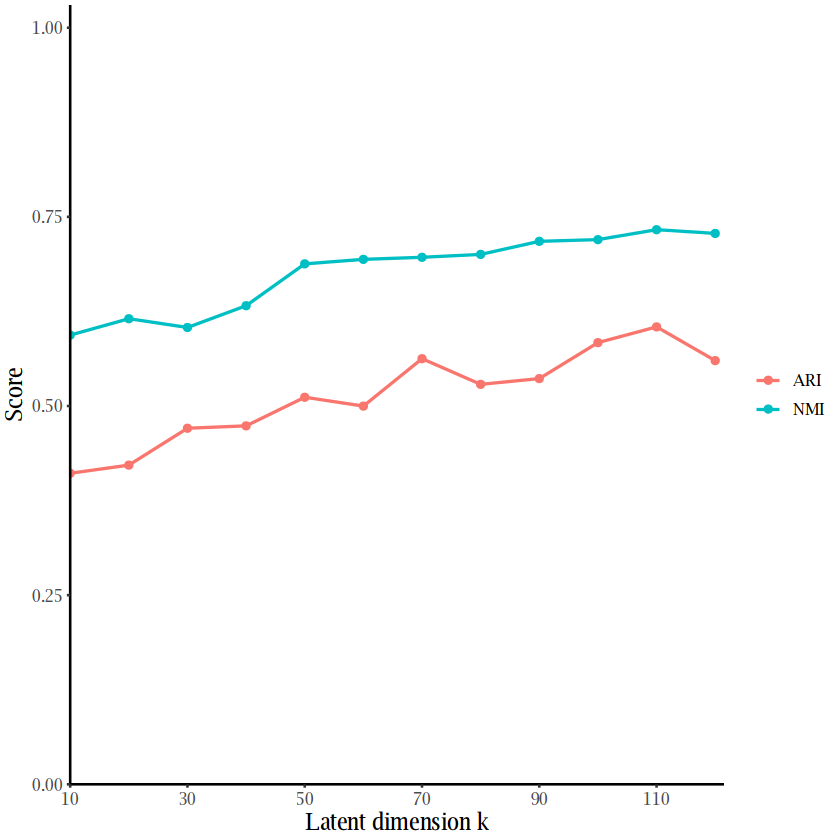

In [3]:
#!/usr/bin/env Rscript

suppressPackageStartupMessages({
  library(readr)
  library(dplyr)
  library(ggplot2)
})

# ---------------- helper theme ----------------
if (!exists("plt_theme")) {
  plt_theme <- theme_classic()
}

# ---------------- load multi-rank ARI / NMI ----------------
ari_path <- file.path(fig_dir, "ARI_values_three_metrics.csv")
nmi_path <- file.path(fig_dir, "NMI_values_three_metrics.csv")

ari_raw <- readr::read_csv(ari_path, show_col_types = FALSE)
nmi_raw <- readr::read_csv(nmi_path, show_col_types = FALSE)

# ---------------- NNAE only (HW) -> long format ----------------
ari_long <- ari_raw %>%
  dplyr::select(k, ARI_HW) %>%
  dplyr::transmute(
    k,
    Metric = "ARI",
    mean   = ARI_HW
  )

nmi_long <- nmi_raw %>%
  dplyr::select(k, NMI_HW) %>%
  dplyr::transmute(
    k,
    Metric = "NMI",
    mean   = NMI_HW
  )

df_plot <- dplyr::bind_rows(ari_long, nmi_long) %>%
  dplyr::mutate(Metric = factor(Metric, levels = c("ARI", "NMI")))

# ---------------- one plot: NNAE ARI + NNAE NMI ----------------
p_nnae_ari_nmi <- ggplot(df_plot, aes(x = k, y = mean, color = Metric, group = Metric)) +
  geom_line(linewidth = 0.7) +
  geom_point(shape = 16, size = 2) +
  scale_x_continuous(
    breaks = seq(min(df_plot$k), max(df_plot$k), by = 20),
    expand = expansion(mult = c(0, 0), add = c(0, 1.5))
  ) +
  scale_y_continuous(
    limits = c(0, 1),
    expand = expansion(mult = c(0, 0), add = c(0, 0.03))
  ) +
  labs(
    x = "Latent dimension k",
    y = "Score",
    color = NULL
  ) +
  plt_theme +
  theme(
    legend.position  = "right",
    axis.title.x     = element_text(family = "serif", size = 14),
    axis.title.y     = element_text(family = "serif", size = 14),
    axis.text.x      = element_text(family = "serif", size = 10),
    axis.text.y      = element_text(family = "serif", size = 10),
    panel.border     = element_blank()
  )

print(p_nnae_ari_nmi)

# ---------------- save ----------------
if (exists("save_pdf")) {
  save_pdf(
    file.path(fig_dir, "nnae_multirank_ARI_NMI.pdf"),
    p_nnae_ari_nmi,
    w = 4.0,
    h = 3.5
  )
}

ggplot2::ggsave(
  file.path(fig_dir, "nnae_multirank_ARI_NMI.png"),
  p_nnae_ari_nmi,
  width  = 4.0,
  height = 3.5,
  units  = "in",
  dpi    = 300,
  bg     = "white"
)